In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt


## Исследование данных

In [2]:
df = pd.read_csv('hotels.csv')
df.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [3]:
# Проверка на пропуски
missing_values = df.isnull().sum()
print("Пропуски в данных:\n", missing_values[missing_values > 0])

# Проверка на дубликаты
duplicates_count = df.duplicated().sum()
print(f"Количество дубликатов: {duplicates_count}")


Пропуски в данных:
 lat    2448
lng    2448
dtype: int64
Количество дубликатов: 307


In [4]:
df.shape

(386803, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:

df['hotel_name'].value_counts()

hotel_name
Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: count, Length: 1492, dtype: int64

In [7]:
# Создаем геокодер с ограничением запросов
geolocator = Nominatim(user_agent="hotel_geocoder_v3")
geocode = RateLimiter(
    geolocator.geocode,
    min_delay_seconds=2,
    max_retries=2,
    error_wait_seconds=5
)

# Находим отели с пропущенными координатами
missing_coords = df[['hotel_name', 'hotel_address']].loc[
    df['lat'].isnull() | df['lng'].isnull()
].drop_duplicates()

print(f"Найдено отелей с пропущенными координатами: {len(missing_coords)}")

for _, row in missing_coords.iterrows():
    hotel = row['hotel_name']
    address = row['hotel_address']
    print(f"\nОбработка: {hotel}")
    print(f"Оригинальный адрес: {address}")
    
    location = None
    try:
        # Попытка 1: оригинальный адрес
        location = geocode(address, timeout=15)
        
        # Попытка 2: удалить только номер дома (если он есть в начале)
        if not location:
            # Используем регулярное выражение для поиска номера дома в начале адреса
            simplified_address = re.sub(r'^\d+\s*', '', address)
            if simplified_address != address:
                print(f"Попытка без номера дома: {simplified_address}")
                location = geocode(simplified_address, timeout=15)
        
        # Попытка 3: использовать название отеля и город
        if not location:
            # Извлекаем город из адреса (последнее слово перед страной)
            parts = address.split()
            if len(parts) > 1:
                city = parts[-2]  # Предпоследнее слово - обычно город
                query = f"{hotel}, {city}"
                print(f"Попытка названия и города: {query}")
                location = geocode(query, timeout=15)
    
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        print(f"Ошибка геокодера: {e}")
        time.sleep(5)
    
    if location:
        lat, lng = location.latitude, location.longitude
        print(f"Найдены координаты: ({lat}, {lng})")
        
        # Обновляем данные
        mask = (df['hotel_name'] == hotel) & (df['hotel_address'] == address) & (df['lat'].isnull() | df['lng'].isnull())
        df.loc[mask, ['lat', 'lng']] = [lat, lng]
    else:
        print("Координаты не найдены")
        # Для ручной проверки проблемных адресов
        with open("problem_addresses.txt", "a") as f:
            f.write(f"{hotel}|{address}\n")

print("\nОбработка завершена!")

Найдено отелей с пропущенными координатами: 17

Обработка: Austria Trend Hotel Schloss Wilhelminenberg Wien
Оригинальный адрес: Savoyenstra e 2 16 Ottakring 1160 Vienna Austria
Попытка названия и города: Austria Trend Hotel Schloss Wilhelminenberg Wien, Vienna
Найдены координаты: (48.2196753, 16.2854959)

Обработка: Holiday Inn Paris Montmartre
Оригинальный адрес: 23 Rue Damr mont 18th arr 75018 Paris France
Попытка без номера дома: Rue Damr mont 18th arr 75018 Paris France
Попытка названия и города: Holiday Inn Paris Montmartre, Paris
Найдены координаты: (48.8716034, 2.3435792)

Обработка: Fleming s Selection Hotel Wien City
Оригинальный адрес: Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria
Попытка названия и города: Fleming s Selection Hotel Wien City, Vienna
Координаты не найдены

Обработка: Hotel Atlanta
Оригинальный адрес: W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria
Попытка названия и города: Hotel Atlanta, Vienna
Найдены координаты: (48.2203284, 16.35582

In [8]:
missing_coords = df[['hotel_name', 'hotel_address']].loc[
    df['lat'].isnull() | df['lng'].isnull()
].drop_duplicates()

print(f"Отели с пропущенными координатами: {missing_coords}")

Отели с пропущенными координатами:                                          hotel_name  \
724             Fleming s Selection Hotel Wien City   
1137         Maison Albar Hotel Paris Op ra Diamond   
1189   Derag Livinghotel Kaiser Franz Joseph Vienna   
1758                      City Hotel Deutschmeister   
5603             Hotel Pension Baron am Schottentor   
6920                Mercure Paris Gare Montparnasse   
25256                                 Hotel Advance   

                                           hotel_address  
724    Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  
1137    4 rue de la P pini re 8th arr 75008 Paris France  
1189   Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  
1758   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  
5603   W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  
6920       20 Rue De La Ga t 14th arr 75014 Paris France  
25256       Sep lveda 180 Eixample 08011 Barcelona Spain  


In [9]:
# Находим координаты вручную и вставляем для оставшихся 7-ми отелей
lat = [48.2008, 48.8664, 48.1888, 48.2028, 48.2036, 48.8431, 52.5056]
lng = [16.3444, 2.3383, 16.3354, 16.3925, 16.3578, 2.3314, 13.3253]
# Обновляем координаты для оставшихся 7 отелей вручную
for i, (idx, row) in enumerate(missing_coords.iterrows()):
    hotel = row['hotel_name']
    address = row['hotel_address']
    mask = (df['hotel_name'] == hotel) & (df['hotel_address'] == address)
    df.loc[mask, ['lat', 'lng']] = [lat[i], lng[i]]
print("Координаты для оставшихся отелей успешно добавлены.")

Координаты для оставшихся отелей успешно добавлены.


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [ ]:
# Одна строка для построения всех гистограмм числовых столбцов
df.hist(figsize=(15, 10), bins=30, edgecolor='black')

## Создание новых признаков

In [11]:
# Преобразуем дату в три отдельных признака
df['review_date'] = pd.to_datetime(df['review_date'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month

In [12]:
# Извлечение страны из адреса отеля и создание новых признаков
df['hotel_country'] = df['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('Kingdom') else x.split()[-1])
print(df[['hotel_address', 'hotel_country']].head())
df['hotel_country'].value_counts()

                                       hotel_address   hotel_country
0  Stratton Street Mayfair Westminster Borough Lo...  United Kingdom
1  130 134 Southampton Row Camden London WC1B 5AF...  United Kingdom
2   151 bis Rue de Rennes 6th arr 75006 Paris France          France
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...          France
4          Molenwerf 1 1014 AG Amsterdam Netherlands     Netherlands


hotel_country
United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: count, dtype: int64

In [13]:
df['reviewer_nationality'].value_counts()
# Создание признака: национальность "Европа" или "Остальные"
european_countries = [
    'United Kingdom', 'France', 'Germany', 'Spain', 'Italy', 'Netherlands', 'Belgium', 'Switzerland',
    'Austria', 'Ireland', 'Portugal', 'Sweden', 'Norway', 'Denmark', 'Finland', 'Poland', 'Czech Republic',
    'Hungary', 'Greece', 'Russia', 'Ukraine', 'Romania', 'Bulgaria', 'Croatia', 'Slovakia', 'Slovenia',
    'Estonia', 'Latvia', 'Lithuania', 'Luxembourg', 'Iceland', 'Serbia', 'Bosnia and Herzegovina',
    'Montenegro', 'Albania', 'Macedonia', 'Belarus', 'Moldova', 'Liechtenstein', 'Monaco', 'San Marino',
    'Andorra', 'Vatican City', 'Malta'
]

df['nationality_group'] = df['reviewer_nationality'].apply(lambda x: 'Europe' if x.strip() in european_countries else 'Other')
print(df['nationality_group'].value_counts())
df['nationality_group'].info()

nationality_group
Europe    267759
Other     119044
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 386803 entries, 0 to 386802
Series name: nationality_group
Non-Null Count   Dtype 
--------------   ----- 
386803 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [14]:
unique_tags_count = df['tags'].str.strip("[]").str.replace("'", "").str.split(', ').explode().nunique()
print('Количество уникальных тегов:', unique_tags_count)
# Создание нового признака: количество слов в тегах
df['tags_word_count'] = df['tags'].str.strip("[]").str.replace("'", "").str.split(', ').apply(len)

# Создание нового признака: наличие слова "Leisure" в тегах
df['has_leisure_tag'] = df['tags'].str.contains('Leisure trip').astype(int)

# Создание нового признака: наличие слова "Business" в тегах
df['has_business_tag'] = df['tags'].str.contains('Business trip').astype(int)

print(df[['tags_word_count', 'has_leisure_tag', 'has_business_tag']].head())


Количество уникальных тегов: 2368
   tags_word_count  has_leisure_tag  has_business_tag
0                5                1                 0
1                4                0                 1
2                5                1                 0
3                4                1                 0
4                4                0                 1


In [15]:
most_common_tag = df['tags'].str.strip("[]").str.replace("'", "").str.split(', ').explode().value_counts().idxmax()
print('Тег, представленный в наибольшем числе отзывов:', most_common_tag)

Тег, представленный в наибольшем числе отзывов:  Leisure trip 


In [16]:
# Извлечение информации о количестве ночей из тегов
nights = df['tags'].str.extract(r'(\d+)\snight')[0].astype(float)
df['nights'] = nights
# Заполняем пропуски модой
mode_value = df['nights'].mode()[0]
df['nights'] = df['nights'].fillna(mode_value)
# Категоризация количества ночей по диапазонам: 0-10, 10-20, 20-30 и т.д.
bins = list(range(0, int(nights.max() or 0) + 10, 10))
labels = [f"{i}-{i+10}" for i in bins[:-1]]
df['nights_group'] = pd.cut(nights, bins=bins, labels=labels, right=False)
# Заполняем пропуски модой
mode_value = df['nights_group'].mode()[0]
df['nights_group'] = df['nights_group'].fillna(mode_value)
print(df['nights_group'].value_counts())


nights_group
0-10     384975
10-20      1743
20-30        85
Name: count, dtype: int64


In [17]:
# Извлечение типа комнаты как третьего элемента после запятой из тегов
df['room_type'] = df['tags'].str.strip("[]").str.replace("'", "").str.split(', ').apply(lambda x: x[2] if len(x) > 2 else None)
# Заполняем пропуски модой
mode_value = df['room_type'].mode()[0]
df['room_type'] = df['room_type'].fillna(mode_value)
print(df['room_type'].value_counts().head())


room_type
Double Room              25567
Standard Double Room     23390
Superior Double Room     22875
Deluxe Double Room       17996
Double or Twin Room      16325
Name: count, dtype: int64


In [18]:
def match_countries(hotel_country, reviewer_nationality):
    # Удаляем пробелы в стране рецензента
    reviewer_nationality = reviewer_nationality.strip()
    
    # Сравниваем и возвращаем 1, если совпадают, 0 если нет
    return 1 if hotel_country == reviewer_nationality else 0

# Применяем функцию к данным
df['is_same_country'] = df.apply(lambda row: match_countries(row['hotel_country'], row['reviewer_nationality']), axis=1)

display(df[['reviewer_nationality', 'hotel_address', 'hotel_country', 'is_same_country']].head())

,reviewer_nationality,hotel_address,hotel_country,is_same_country
0,United Kingdom,Stratton Street Mayfair Westminster Borough Lo...,United Kingdom,1
1,United Kingdom,130 134 Southampton Row Camden London WC1B 5AF...,United Kingdom,1
2,China,151 bis Rue de Rennes 6th arr 75006 Paris France,France,0
3,United Kingdom,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,France,0
4,Poland,Molenwerf 1 1014 AG Amsterdam Netherlands,Netherlands,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

- **review_year, review_month** — позволяют учитывать сезонность и временные тренды в отзывах.
- **hotel_country, is_same_country** — страна отеля и совпадение с национальностью рецензента, отражают культурные особенности и ожидания гостей.
- **nationality_group** — группировка национальностей (Европа/Остальные), помогает выявить различия в оценках между группами.(этот признак можно улучшить, вначале попробовав разделить на две почти равные группы)
- **tags_word_count, has_leisure_tag, has_business_tag** — особенности поездки (досуг/бизнес), количество тегов, что может отражать цель визита и степень детализации отзыва.
- **nights_group, room_type (encoded_room_type)** — длительность проживания и тип комнаты, могут влиять на итоговую оценку.
- **lat, lng** — географические координаты, позволяют учитывать расположение отеля.
- **review_total_positive_word_counts, review_total_negative_word_counts** — количество позитивных и негативных слов, напрямую связано с оценкой.

Эти признаки расширяют исходные данные, позволят модели лучше улавить скрытые зависимости и потенциально повышают качество предсказаний.

## Кодирование категориальных признаков.

In [20]:
# Кодирование номинальных категориальных признаков "hotel_country"
# Используем pd.get_dummies(), так как это проще для pandas DataFrame

df = pd.get_dummies(df, columns=['hotel_country'], drop_first=True)
print(df.filter(like='hotel_country_').head())

   hotel_country_France  hotel_country_Italy  hotel_country_Netherlands  \
0                 False                False                      False   
1                 False                False                      False   
2                  True                False                      False   
3                  True                False                      False   
4                 False                False                       True   

   hotel_country_Spain  hotel_country_United Kingdom  
0                False                          True  
1                False                          True  
2                False                         False  
3                False                         False  
4                False                         False  


In [21]:
# Кодируем признак "nationality_group"
df = pd.get_dummies(df, columns=['nationality_group'], prefix='nationality', drop_first=True)
print(df.filter(like='nationality_').head()) 

   nationality_Other
0              False
1              False
2               True
3              False
4              False


In [22]:
# Кодируем признак "nights_group" с помощью OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
df['nights_group_encoded'] = ordinal_encoder.fit_transform(df[['nights_group']])

print(df[['nights_group', 'nights_group_encoded']].tail())

       nights_group  nights_group_encoded
386798         0-10                   0.0
386799         0-10                   0.0
386800         0-10                   0.0
386801         0-10                   0.0
386802         0-10                   0.0


In [23]:
# Кодируем признак тип комнаты с помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['encoded_room_type'] = label_encoder.fit_transform(df['room_type'])
# Выводим первые несколько строк
print(df[['tags', 'encoded_room_type']].head())

                                                tags  encoded_room_type
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...               1819
1  [' Business trip ', ' Couple ', ' Standard Dou...               1679
2  [' Leisure trip ', ' Solo traveler ', ' Modern...               1304
3  [' Leisure trip ', ' Solo traveler ', ' Standa...               1739
4  [' Business trip ', ' Couple ', ' Standard Dou...               1707


- Для признаков "hotel_country", "nationality_group" применено one-hot-кодирование с помощью `pd.get_dummies()`.
- Признак "room_type" закодирован с помощью `LabelEncoder` (целочисленное кодирование).
- Признак "nights_group" закодирован с помощью `OrdinalEncoder` (порядковое кодирование).
- Булевы признаки (например, "has_leisure_tag", "has_business_tag", "is_same_country") представлены как 0/1.

## Анализ мультиколлинеарности

In [24]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 'tags_word_count',
            'average_score', 'lat', 'lng', 'nights']

# категориальные признаки
cat_cols = ['nights_group_encoded', 'hotel_country_spain', 'hotel_country_netherlands', 
            'hotel_country_kingdom', 'hotel_country_italy', 'hotel_country_france', 'is_same_country',
            'has_business_tag', 'has_leisure_tag', 'encoded_room_type']

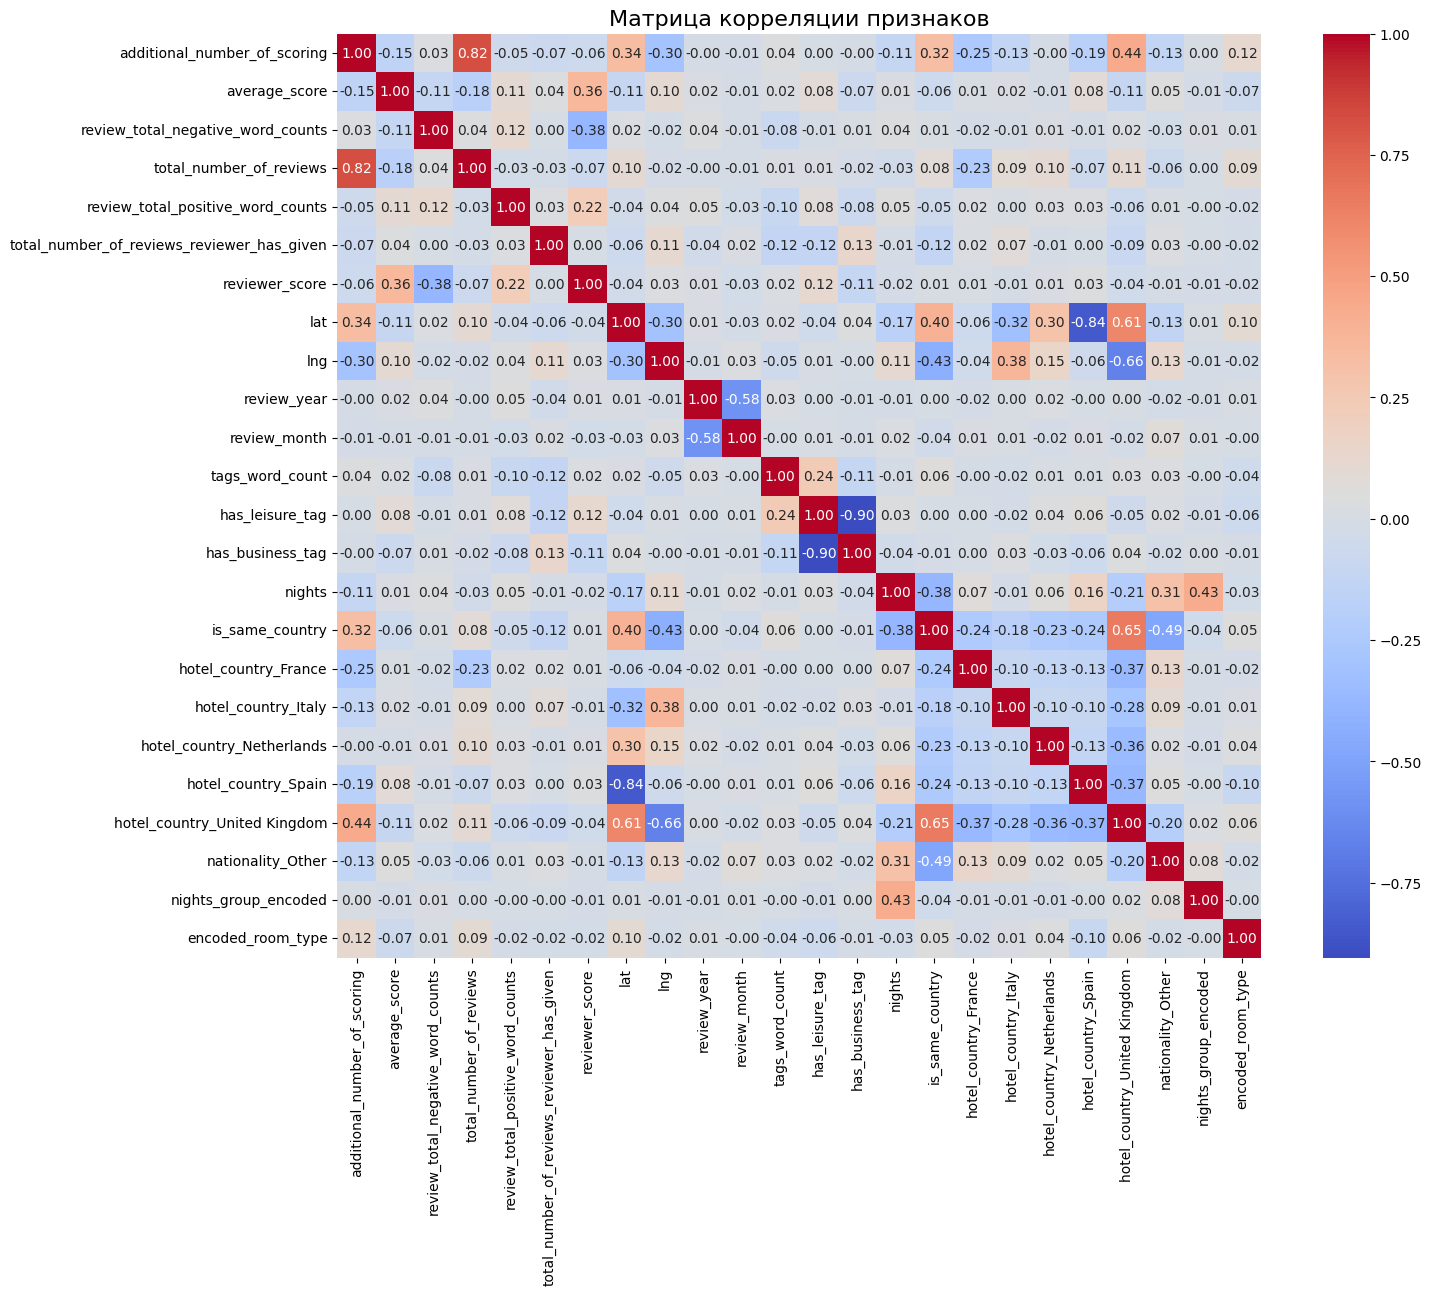

In [25]:
plt.figure(figsize=(16, 12))

# Строим корреляционную матрицу
corr_matrix = df.corr(numeric_only=True)

# Визуализируем
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Матрица корреляции признаков', fontsize=16)
plt.show()


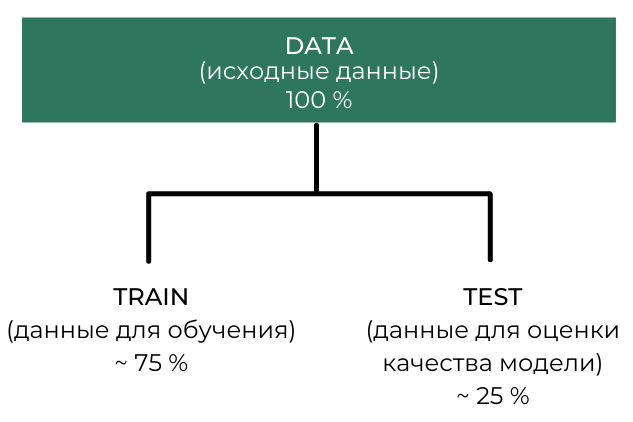

In [26]:
# Удаляем object и datetime столбцы

object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)
df.drop('nights_group', axis=1, inplace=True)
df = df.drop(columns=['review_date', 'total_number_of_reviews']) # 'total_number_of_reviews' удаляем по признаку мультиколлинеарности
# Разбиваем датасет на части, необходимые для обучения и тестирования модели
# # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = df.drop(['reviewer_score'], axis = 1)  
y = df['reviewer_score']  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<Axes: >

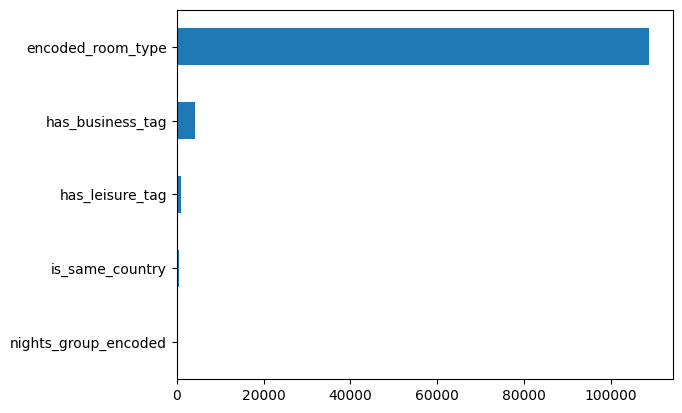

In [27]:
# Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат
y = y.astype('int')

from sklearn.feature_selection import chi2  # хи-квадрат
cat_cols = [col for col in cat_cols if col in X.columns]
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<Axes: >

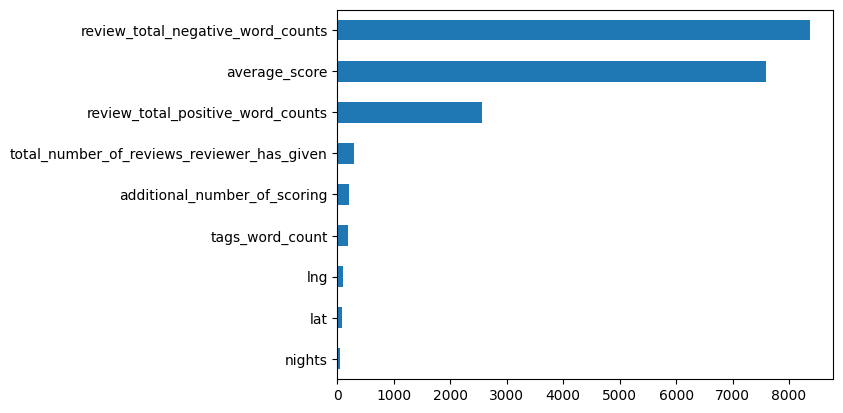

In [28]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [29]:
# Поверяем перед обучением
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 290102 entries, 22852 to 121958
Data columns (total 22 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                290102 non-null  int64  
 1   average_score                               290102 non-null  float64
 2   review_total_negative_word_counts           290102 non-null  int64  
 3   review_total_positive_word_counts           290102 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  290102 non-null  int64  
 5   lat                                         290102 non-null  float64
 6   lng                                         290102 non-null  float64
 7   review_year                                 290102 non-null  int32  
 8   review_month                                290102 non-null  int32  
 9   tags_word_count                             290102 non-null  int64  
 1

In [30]:
    # Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [31]:
 # Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
    # Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13643727760872515


**Общий вывод**

В ходе работы был проведён полный цикл анализа и подготовки данных для задачи прогнозирования рейтинга отелей на основе отзывов гостей. Данные были очищены от пропусков, для отелей с отсутствующими координатами были найдены или вручную добавлены значения широты и долготы. Проведено создание новых признаков, отражающих сезонность, страну, национальность, особенности поездки и длительность проживания. Категориальные признаки были закодированы подходящими способами (one-hot, порядковое и метки). Выполнён анализ мультиколлинеарности и значимости признаков. На финальном этапе построена и обучена модель, проведена оценка её качества. Полученные результаты показывают, что построенная модель способна  предсказывать оценки гостей, а созданные признаки вносят вклад в объяснение вариации рейтингов. Такой подход может быть использован для дальнейшего улучшения сервиса и персонализации предложений для клиентов гостиничного бизнеса. Есть несколько признаков, вариативное преобразование которых возможно позволит улучшить полученные результаты метрики.